### Support Vector Machines

Dimensionality Reduction / Feature Selection

In [48]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading the dataset, splitting into X, y train and test. Defining a dictionary for the labels. 

In [50]:
#define relative path to dataset in local memory
#path_train = '../data/external/sign_mnist_train.csv'
#path_test = '../data/external/sign_mnist_test.csv'

#define path to colab data 
path_train = '/content/drive/Shareddrives/SignLanguageData/28_28_images/sign_mnist_train.csv'
path_test = '/content/drive/Shareddrives/SignLanguageData/28_28_images/sign_mnist_test.csv'


#define image resolution 
res = (28,28)

#saving data into pandas dataframes 
train = pd.read_csv(path_train)
test = pd.read_csv(path_test)

#training data 
X_train = train.iloc[:,1:]
y_train = train.iloc[:,0]

#testing data
X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

In [51]:
#letters
letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
#numbers 
numbers = sorted(list(y_train.unique()))
#dictionary of labels 
labels = dict(zip(numbers,letters))

From the initial modeling results for this dataset, the normal (not reduced to images of edges) re-scaled using standardization produced the best results. As a result, standardized normal images will be used for the remainder of this notebook.

In [52]:
#define sklearn standard scaler object and fit to training data 
sc = StandardScaler().fit(X_train)
#transform training and testing data 
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

Dimensionality reduction is an important step in the Data Science pipeline because it reduces the complexity of the model by reducing the number of input features. This results in a decreased likelihood for the model to overfit on the training data. Additionally, removing noise and unimportant/redundant features can lead to better performing models. Lastly, reducing dimensionality will decrease the computational and memory requirements to train and use the model. 

Linear Discriminant Analysis is a linear supervised learning algorithm used for classification tasks by projecting the data to a lower dimensionality that maximizes the separation between classes. This is achieved by finding the vectors in the feature space that best separates the different classes of the data and minimizes the variance of the data within each class. 

In [53]:
#define sklearn LDA object 
lda = LinearDiscriminantAnalysis()
#fit on training data 
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis()

The explained variance ratio of the LDA components (linear discriminants) indicate how much information is retained at each component. As a result, the cumulative explained variance can help determine how many components to keep for dimensionality reduction. 

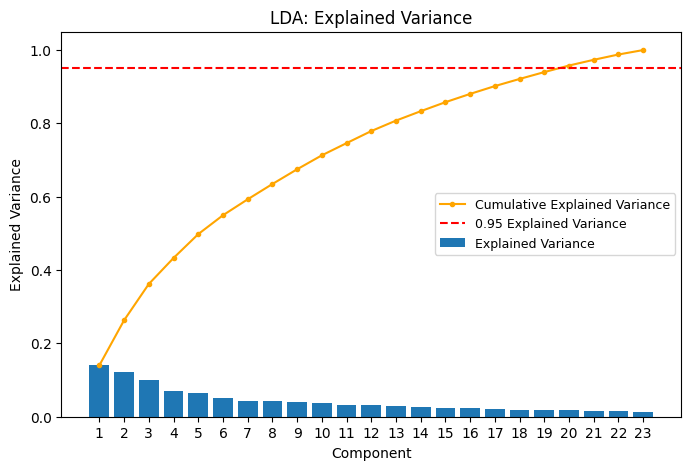

In [54]:
#getting explained variance ratio from the lda model 
evr = lda.explained_variance_ratio_
components = range(1, len(evr) + 1)

#plotting scree plot
fig, ax = plt.subplots(figsize = (8,5))
ax.bar(x = components, height = evr, label = 'Explained Variance');
plt.plot(components, np.cumsum(evr), marker = '.', color = 'orange', label = 'Cumulative Explained Variance')
plt.axhline(y = .95, color = 'r', linestyle = '--', label = '0.95 Explained Variance')
plt.xticks(range(1, len(evr)+1));
plt.title('LDA: Explained Variance');
plt.xlabel('Component');
plt.ylabel('Explained Variance');
plt.legend(fontsize = 9);

Looking at the plot above, it can be interpreted that there is an elbow at around component 3 - 5, however, this would only account for about .35 - .55 of the cumulative variance explained. As a result, for the purposes of modeling, all components resulted from the LDA computation will be used. 

This results in a dimensionality reduction of 784 to 23. 

In [55]:
#fit on training data and transform
X_train_lda = lda.fit_transform(X_train,y_train)
X_test_lda = lda.transform(X_test)

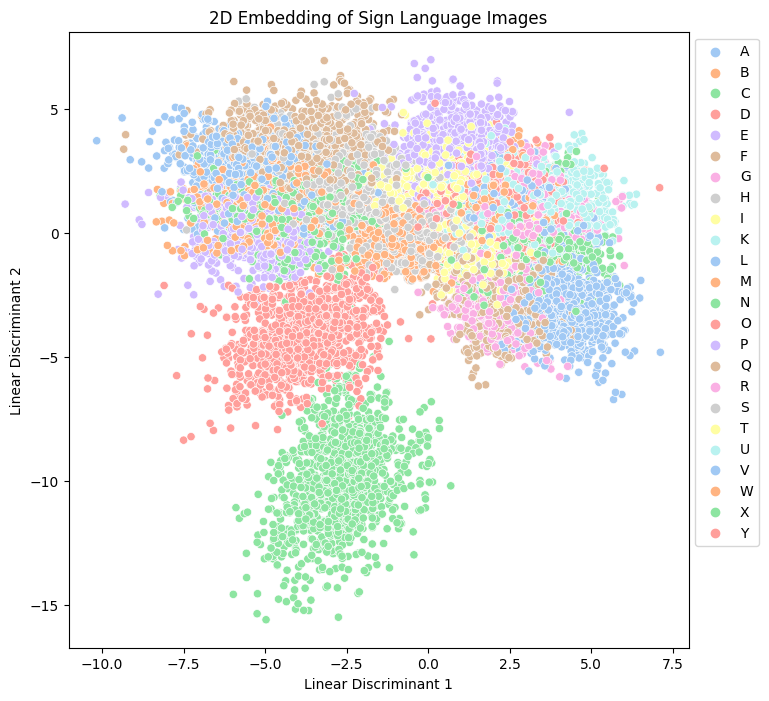

In [56]:
fig, ax = plt.subplots(figsize = (8,8))
ax = sns.scatterplot(x = X_train_lda[:,0], y = X_train_lda[:,1], hue = y_train, palette = 'pastel');
handler, _ = ax.get_legend_handles_labels();
plt.legend(handler, letters, bbox_to_anchor = (1, 1));
plt.title('2D Embedding of Sign Language Images')
plt.xlabel('Linear Discriminant 1');
plt.ylabel('Linear Discriminant 2');

Plotting components 1 and 2 from the LDA computation, it is observed that it does reasonably well at separating certain letters from others. For example, X and Y is separated well from the other letters using the first two linear discriminants. The other letters likely require more components to result in a clearer separation between the classes.

#### Modeling with SVM

Hyperparameter tuning is an important step in modeling, where the values chosen for a model's hyperparameters can drastically change the performance of the model. Grid Search CV and Randomized Grid Search are methods to find the optimal values that results in the best performing model. 

Grud Search is an exhaustive search algorithm that tries every combination of each set of hyperparameters, and determines which results in the best model. Randomized Grid Search randomly chooses combinations of hyperarameters, which results in less computational requirments but does not guarantee the best performing model is found. However, with a sufficiently high n_iter value, it is likely a close to best performing model is found. 

For this investigation, randomized search will be used. 

The important hyperparameters for SVM are kernel, C, and gamma. These will be defined in a dictionary as an input for Randomized Search CV. 

In [57]:
#defining support vector machine parameters
parameters = {
    'kernel':['linear','poly','rbf','sigmoid'], 
    'gamma':['scale','auto'],
    'C':np.linspace(0.01,10,20)
    }

Randomized Search on LDA Transformed Training Data

In [32]:
#defining randomized grid search cv 
clf = RandomizedSearchCV(SVC(), param_distributions=parameters, random_state=99, verbose=3)

#fitting to LDA transformed training data 
search_lda = clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END C=5.793684210526316, gamma=scale, kernel=sigmoid;, score=0.999 total time=   1.0s
[CV 2/5] END C=5.793684210526316, gamma=scale, kernel=sigmoid;, score=0.998 total time=   1.0s
[CV 3/5] END C=5.793684210526316, gamma=scale, kernel=sigmoid;, score=0.998 total time=   1.0s
[CV 4/5] END C=5.793684210526316, gamma=scale, kernel=sigmoid;, score=0.998 total time=   1.1s
[CV 5/5] END C=5.793684210526316, gamma=scale, kernel=sigmoid;, score=0.998 total time=   1.5s
[CV 1/5] END C=2.6389473684210527, gamma=auto, kernel=rbf;, score=1.000 total time=   6.0s
[CV 2/5] END C=2.6389473684210527, gamma=auto, kernel=rbf;, score=1.000 total time=   4.6s
[CV 3/5] END C=2.6389473684210527, gamma=auto, kernel=rbf;, score=1.000 total time=   5.7s
[CV 4/5] END C=2.6389473684210527, gamma=auto, kernel=rbf;, score=1.000 total time=   4.6s
[CV 5/5] END C=2.6389473684210527, gamma=auto, kernel=rbf;, score=0.999 total time=   5.4s
[CV 1/5] 

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [63]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [64]:
lr_lda = LogisticRegression(max_iter=300)
lr_lda.fit(X_train_lda,y_train)

LogisticRegression(max_iter=300)

In [65]:
lr.score(X_train,y_train)

1.0

In [66]:
lr.score(X_test,y_test)

0.6986893474623536

In [67]:
lr_lda.score(X_train_lda,y_train)

0.9998907302859225

In [69]:
lr_lda.score(X_test_lda,y_test)

0.3930563301728946

In [43]:
y_pred = lr.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.58      0.76      0.66       331
           1       0.62      0.66      0.64       432
           2       0.81      0.75      0.78       310
           3       0.45      0.60      0.51       245
           4       0.81      0.61      0.70       498
           5       0.32      0.35      0.33       247
           6       0.55      0.37      0.44       348
           7       0.70      0.48      0.57       436
           8       0.23      0.19      0.21       288
          10       0.27      0.34      0.30       331
          11       0.28      0.27      0.28       209
          12       0.29      0.18      0.22       394
          13       0.28      0.28      0.28       291
          14       0.52      0.33      0.41       246
          15       0.84      0.09      0.17       347
          16       0.31      0.40      0.35       164
          17       0.00      0.01      0.00       144
          18       0.17    